본 과제의 출처는 https://github.com/WegraLee/deep-learning-from-scratch-2/tree/master 으로, 해당 repo에서 모듈 몇 가지만 발췌해온 것입니다.

In [1]:
import numpy as np

## CBOW model 구현



강의에서 배운 CBOW의 가장 기초적인 버전을 직접 구현해볼 것입니다.

SimpleCBOW라는 이름의 class를 만들어줄 것인데 그 전에 앞서 activation function, loss function, optimizer 등을 정의해줍니다. 강의 내용과 직결되는 부분은 아니니, 빠르게 실행하고 넘어가도 좋습니다.

In [2]:
# coding: utf-8
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


### activation, loss function 정의

In [3]:
# coding: utf-8

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

### 그 외 학습에 필요한 class 정의

In [4]:
# coding: utf-8
import numpy
import time
import matplotlib.pyplot as plt


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

optimizer로 `Adam`을 정의해줍니다.

In [5]:
# coding: utf-8
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])

            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)


In [6]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

### SimpleCBOW

이제부터가 중요한 부분이니, 강의에서 배웠던 내용을 떠올리며 코드를 실행해보세요! 아래 도식화를 직접 layer를 쌓아 구현해볼 것입니다.

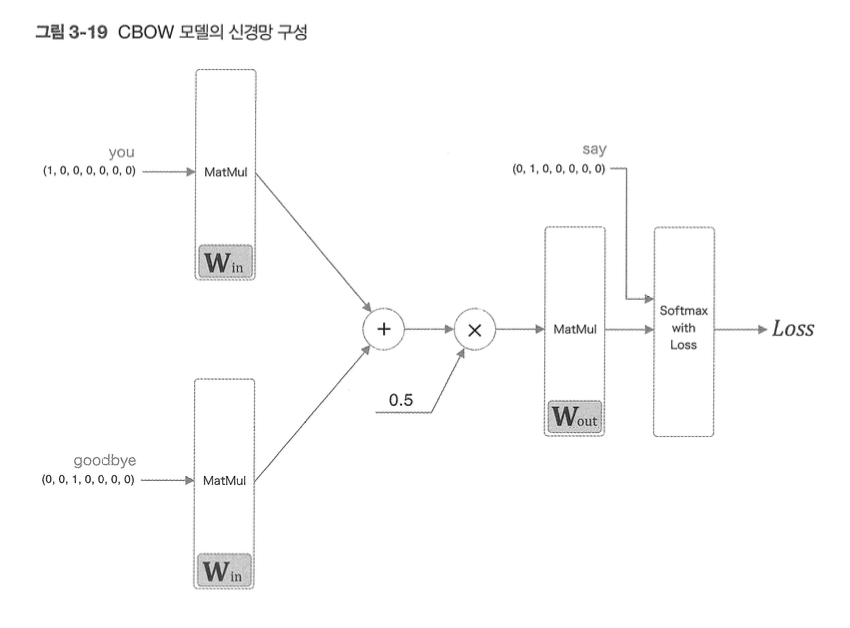

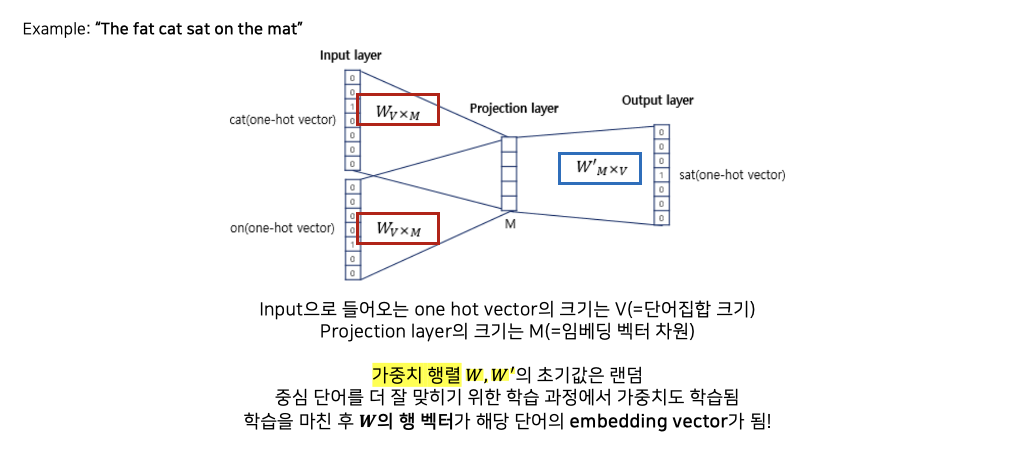

아래 신경망은 `window_size=1`인 경우를 가정합니다.

코드 셀에서 `'답?'`이라고 된 부분에 여러분이 생각하시는 답을 적어주세요!


In [7]:
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H= vocab_size, hidden_size

    # 가중치 초기화
    '''
    문제 1: 가중치 행렬 w_in과 w_out의 차원은 무엇일까요? 위에서 주어진 강의안 슬라이드를 보고 생각해보세요!
    '''
    W_in = 0.01 * np.random.randn('답?', '답?').astype('f')
    W_out = 0.01 * np.random.randn('답?', '답?').astype('f')



    # 계층 생성
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)


    '''
    문제 2: loss_layer에서 사용할 loss function은 무엇일까요?
    초반부에 'activation, loss function 정의' 코드 셀에 정의된 함수 중 가장 적절한 것을 골라 넣으시면 됩니다!
    '''
    self.loss_layer = '답?'()



    # 모든 가중치와 기울기를 리스트에 모은다.
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장한다.
    self.word_vecs = W_in

  def forward(self, contexts, target):
      h0 = self.in_layer0.forward(contexts[:, 0])
      h1 = self.in_layer1.forward(contexts[:, 1])

      '''
      문제 3: 아래 빈칸 수식을 채워넣어보세요.
      hint: h는 projection layer에 해당하는 부분이며, window size는 1로 고정되어 있습니다.
      projection layer의 역할을 곱씹어보세요.
      직전에 lookup해온 h0과 h1을 사용하여 간단하게 작성할 수 있습니다.
      '''
      h = '답?'


      score = self.out_layer.forward(h)
      loss = self.loss_layer.forward(score, target)
      return loss

  def backward(self, dout=1):
      ds = self.loss_layer.backward(dout)
      da = self.out_layer.backward(ds)
      da *= 0.5
      self.in_layer1.backward(da)
      self.in_layer0.backward(da)
      return None

### Train SimpleCBOW

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

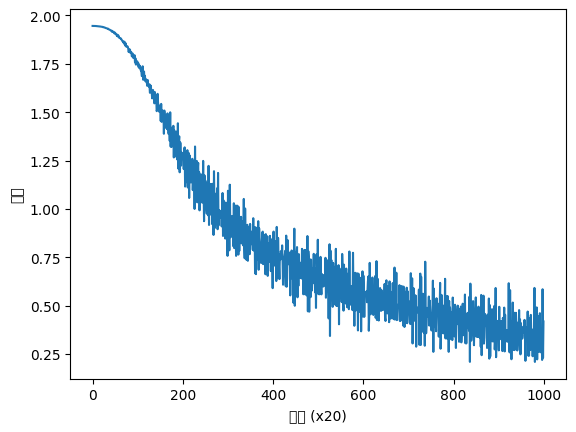

you [-0.63189083 -0.8820022  -0.91441923 -1.2120262  -1.6475637 ]
say [ 1.2313708   1.255028    0.6114998  -1.2180315  -0.13898833]
goodbye [-1.3331985  -1.1520845  -1.0686167  -0.47511822  0.28024042]
and [ 1.0060079   0.99575263  1.5472975  -0.39308435 -1.5013789 ]
i [-1.3339822  -1.1718694  -1.0716755  -0.47604126  0.313805  ]
hello [-0.61328125 -0.8977921  -0.89010763 -1.215788   -1.6654917 ]
. [ 1.1058758  1.1117405 -1.5489368 -1.2657117  1.3967345]


In [19]:
# coding: utf-8

window_size = 1 # window size는 1로 고정.
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

학습이 끝난 후 모델에 저장된 가중치 행렬의 행들을 갖고와 봅시다. 이것들이 바로 각 단어의 **embedding vector**가 됩니다.

기존의 크기가 7이었던 one hot vector는 이제 실수값을 갖는 크기 5의 밀집 벡터로 표현되었습니다.

위 코드 셀에서 여러분이 원하는 text를 넣어 embedding vector를 얻어보세요!

In [20]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-0.63189083 -0.8820022  -0.91441923 -1.2120262  -1.6475637 ]
say [ 1.2313708   1.255028    0.6114998  -1.2180315  -0.13898833]
goodbye [-1.3331985  -1.1520845  -1.0686167  -0.47511822  0.28024042]
and [ 1.0060079   0.99575263  1.5472975  -0.39308435 -1.5013789 ]
i [-1.3339822  -1.1718694  -1.0716755  -0.47604126  0.313805  ]
hello [-0.61328125 -0.8977921  -0.89010763 -1.215788   -1.6654917 ]
. [ 1.1058758  1.1117405 -1.5489368 -1.2657117  1.3967345]
